In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from scipy import signal
from scipy.signal import correlate

In [2]:
# dark theme
plt.style.use('dark_background')

# customize the style
plt.rcParams.update({
    'figure.facecolor': '#131416',
    'axes.facecolor': '#131416',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'axes.prop_cycle': plt.cycler(color=plt.cm.tab10.colors),  # use standard matplotlib colors
})

In [3]:
import neuron
from neuron import h

In [4]:
import os
home = os.path.expanduser("~")
model_name = 'Park_2019'
path_to_model = os.path.join(home, 'Documents', 'code', 'DendroTweaksLab', 'DendroTweaks', 'examples', model_name)
path_to_data = os.path.dirname(path_to_model)

In [5]:
import sys
sys.path.append(path_to_model)
from Park_2019_NEURON import Cell, run, load_mechanisms

In [6]:
# from neuron import h
# import matplotlib.pyplot as plt
# import numpy as np

# # Initialize NEURON
# h.load_file('stdrun.hoc')

# # Create two neurons
# class SimpleNeuron:
#     def __init__(self, name):
#         self.name = name
        
#         # Create soma
#         self.soma = h.Section(name=f'{name}_soma')
#         self.soma.L = 20      # Length in um
#         self.soma.diam = 20   # Diameter in um
#         self.soma.Ra = 100    # Axial resistance in ohm-cm
        
#         # Insert Hodgkin-Huxley channels
#         self.soma.insert('hh')
        
#         # Record voltage
#         self.v_vec = h.Vector()
#         self.v_vec.record(self.soma(0.5)._ref_v)
        
#         # Record spike times
#         self.spike_detector = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
#         self.spike_detector.threshold = 0  # mV
#         self.spike_times = h.Vector()
#         self.spike_detector.record(self.spike_times)

# # Create the two neurons
# neuron1 = SimpleNeuron("Neuron1")
# neuron2 = SimpleNeuron("Neuron2")

# # Create current clamp for neuron1
# stim = h.IClamp(neuron1.soma(0.5))
# stim.delay = 100   # ms
# stim.dur = 50      # ms
# stim.amp = 0.8     # nA

# # Create a synapse on neuron2
# syn = h.ExpSyn(neuron2.soma(0.5))
# syn.tau = 2        # ms
# syn.e = 0          # mV (excitatory synapse)

# # Connect neuron1 to neuron2 via the synapse
# nc = h.NetCon(neuron1.soma(0.5)._ref_v, syn, sec=neuron1.soma)
# nc.threshold = 0    # mV
# nc.weight[0] = 0.05 # synaptic weight
# nc.delay = 1        # ms

# # Set up recording of time
# time_vec = h.Vector()
# time_vec.record(h._ref_t)

# # Run the simulation
# h.tstop = 300  # ms
# h.dt = 0.025   # ms
# h.v_init = -65 # mV
# h.run()

# # Convert vectors to numpy arrays for plotting
# time = np.array(time_vec)
# v1 = np.array(neuron1.v_vec)
# v2 = np.array(neuron2.v_vec)
# spikes1 = np.array(neuron1.spike_times)
# spikes2 = np.array(neuron2.spike_times)

# # Create plot
# plt.figure(figsize=(10, 6))

# # Plot membrane potentials
# plt.subplot(2, 1, 1)
# plt.plot(time, v1, 'b', label='Neuron 1')
# plt.plot(time, v2, 'r', label='Neuron 2')
# plt.xlabel('Time (ms)')
# plt.ylabel('Membrane Potential (mV)')
# plt.title('Two Connected Neurons with Current Clamp')
# plt.legend()

# # Plot spike raster
# plt.subplot(2, 1, 2)
# if len(spikes1) > 0:
#     plt.vlines(spikes1, 0.9, 1.1, colors='b', label='Neuron 1 Spikes')
# if len(spikes2) > 0:
#     plt.vlines(spikes2, 1.9, 2.1, colors='r', label='Neuron 2 Spikes')
# plt.ylim(0.5, 2.5)
# plt.yticks([1, 2], ['Neuron 1', 'Neuron 2'])
# plt.xlabel('Time (ms)')
# plt.title('Spike Raster')
# plt.legend()

# plt.tight_layout()
# plt.show()

# print(f"Neuron 1 spike times: {spikes1}")
# print(f"Neuron 2 spike times: {spikes2}")
# print(f"Synaptic connection strength: {nc.weight[0]}")
# print(f"Synaptic delay: {nc.delay} ms")

In [7]:
morpho = os.path.join(path_to_model, 'morphology', 'Park_2019_sorted.swc')
mod = os.path.join(path_to_model, 'membrane', 'temp_mod')

In [8]:
load_mechanisms(mod);

Loaded mod files from "/home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples/Park_2019/membrane/temp_mod"


# Network

In [9]:
import random


# Create 20 neurons
n_cells = 10
cells = [Cell(morpho) for _ in range(n_cells)]  # Assuming you have a Cell() class

# Connectivity parameters
p_connect = 0.2  # 20% probability of connection
weights = 0.02  # Synaptic weight
syn_delay = 5.0  # Synaptic delay in ms

# Storage for connections and synapses
netcons = []
synapses = []
conn_matrix = np.zeros((n_cells, n_cells))


In [10]:
# Create random connections
for pre in range(n_cells):
    for post in range(n_cells):
        if pre != post and random.random() < p_connect:
            syn = h.ExpSyn(cells[post].soma[0](0.5))  # AMPA synapse
            syn.tau = 2.0
            syn.e = 0.0
            nc = h.NetCon(cells[pre].soma[0](0.5)._ref_v, syn, sec=cells[pre].soma[0])
            nc.threshold = 0
            nc.weight[0] = weights
            nc.delay = syn_delay
            synapses.append(syn)
            netcons.append(nc)
            conn_matrix[pre, post] = 1

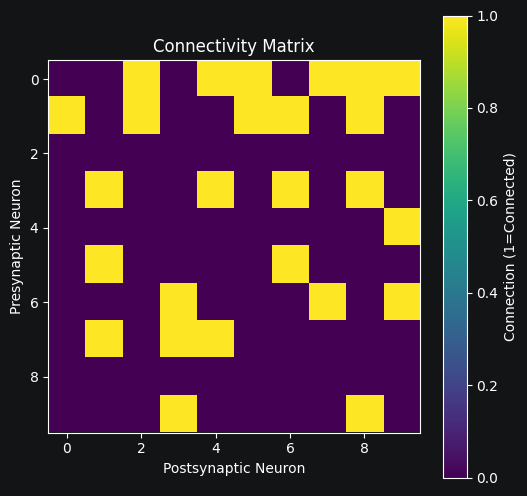

In [11]:
# Plot connectivity matrix
plt.figure(figsize=(6, 6))
plt.imshow(conn_matrix, cmap='viridis', interpolation='none')
plt.ylabel("Presynaptic Neuron")
plt.xlabel("Postsynaptic Neuron")
plt.title("Connectivity Matrix")
plt.colorbar(label="Connection (1=Connected)")
plt.show()

In [12]:
# # Background input using NetStim
# stim_interval = 10  # Poisson-like input
# stim_weight = 0.001
# background_synapses = []
# background_stims = []
# background_netcons = []
# n_per_cell = 100

# for cell in cells:
#     for _ in range(n_per_cell):
#         stim = h.NetStim()
#         stim.start = 0
#         stim.number = 10
#         stim.interval = stim_interval
#         idx = random.randint(0, len(cell.apic) - 1)
#         syn = h.ExpSyn(cell.apic[idx](0.5))
#         syn.tau = 2.0
#         syn.e = 0.0
#         nc = h.NetCon(stim, syn)
#         nc.weight[0] = stim_weight
#         background_synapses.append(syn)
#         background_stims.append(stim)
#         background_netcons.append(nc)


In [13]:
# Spike recording
detectors = []
spike_times = h.Vector()
spike_gids = h.Vector()

for i, cell in enumerate(cells):
    spike_detector = h.NetCon(cell.soma[0](0.5)._ref_v, None, sec=cell.soma[0])
    spike_detector.threshold = 0
    spike_detector.record(spike_times, spike_gids, i)
    detectors.append(spike_detector)

In [14]:
# recode soma voltage
recordings = []

for cell in cells:
    rec = h.Vector()
    rec.record(cell.soma[0](0.5)._ref_v)
    recordings.append(rec)

t = h.Vector()
t.record(h._ref_t)

Vector[12]

In [15]:
iclamps = []

iclamp = h.IClamp(cells[0].soma[0](0.5))
iclamp.delay = 50.0
iclamp.dur = 100.0
iclamp.amp = 0.200
iclamps.append(iclamp)

iclamp = h.IClamp(cells[-1].soma[0](0.5))
iclamp.delay = 50.0
iclamp.dur = 100.0
iclamp.amp = 0.200
iclamps.append(iclamp)

In [16]:
run(300, temperature=37, v_init=-79)

In [17]:
import networkx as nx

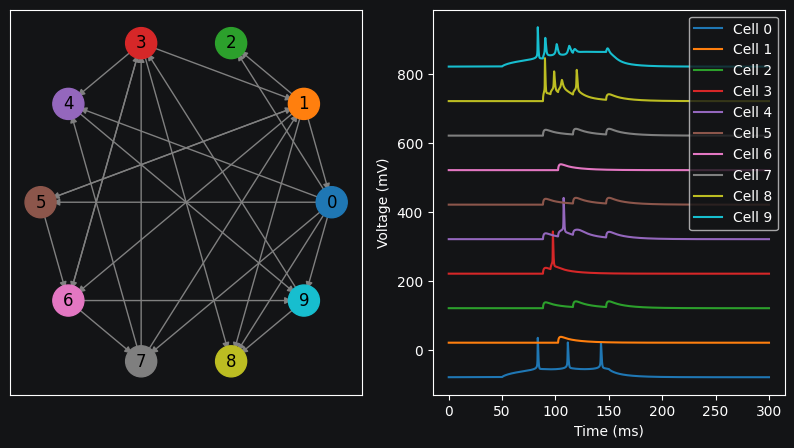

In [18]:
# Plot somatic voltages one above the other

tt = np.array(t)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Plot connectivity as an arrow plot (i.e. two columns of points and connectors) with same colors as the spikes
# ax = axes[0]
# for pre in range(n_cells):
#     ax.plot(0, pre, 'o', color=f'C{pre}', markersize=10)
#     ax.plot(1, pre, 'o', color=f'C{pre}', markersize=10)
#     for post in range(n_cells):    
#         if conn_matrix[pre, post]:
#             ax.plot([0, 1], [pre, post], '->', color=f'C{pre}')

# Plot connectivity as a graph with circular layout
G = nx.DiGraph()
for pre in range(n_cells):
    G.add_node(pre, color=f'C{pre}')
for pre in range(n_cells):
    for post in range(n_cells):
        if conn_matrix[pre, post]:
            G.add_edge(pre, post)
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, ax=axes[0], node_color=[node[1]['color'] for node in G.nodes(data=True)], node_size=500)
nx.draw_networkx_edges(G, pos, ax=axes[0], edge_color='gray')
nx.draw_networkx_labels(G, pos, ax=axes[0])

# Plot spikes
ax = axes[1]
for i, cell in enumerate(cells):
    ax.plot(tt, np.array(recordings[i]) + i * 100, label=f'Cell {i}')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.legend()

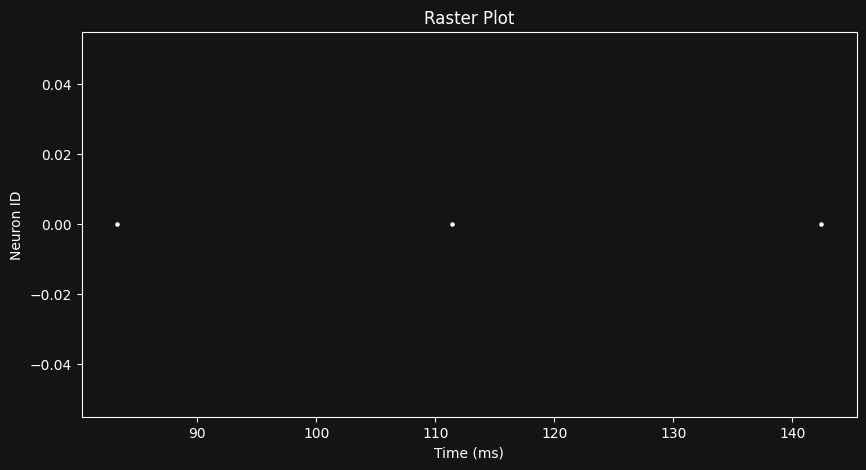

In [19]:
# Plot raster plot
plt.figure(figsize=(10, 5))
plt.scatter(spike_times.to_python(), spike_gids.to_python(), s=5, c='w')
plt.xlabel("Time (ms)")
plt.ylabel("Neuron ID")
plt.title("Raster Plot")
plt.show()